In [45]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import proc_cesm_le

In [46]:
files = sorted(glob(os.path.join(diro['out'],'volume_timeseries.ann_dft.ens_i_???.nc')))
ds = []
for i,f in enumerate(files):
    dsi = xr.open_dataset(f,decode_times=False,decode_coords=False)
    dsi = dsi.drop([v for v in dsi if v not in ['V5INT','V50INT','V60INT']])    
    ds.append(dsi)
ds = xr.concat(ds,dim='ens')
ds['time'] = xr.DataArray(np.arange(1920,2101,1),dims=('time'))
print ds

<xarray.Dataset>
Dimensions:  (ens: 33, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Dimensions without coordinates: ens
Data variables:
    V60INT   (ens, time) float64 1.077e+17 1.077e+17 1.077e+17 1.076e+17 ...
    V50INT   (ens, time) float64 8.847e+16 8.835e+16 8.829e+16 8.824e+16 ...
    V5INT    (ens, time) float64 1.602e+16 1.584e+16 1.606e+16 1.608e+16 ...
Attributes:
    history:  Mon Oct 23 10:27:00 2017: ncks -O -4 tr85.001.ann_dft.O2.1920-2...
    NCO:      4.6.7


### compute ensemble mean of CESM-LE

In [47]:
dsa = ds.mean(dim='ens')
dss = ds.std(dim='ens')

cesm_baseline = dsa.sel(time=slice(1920,1939)).mean(dim='time')
print cesm_baseline

dsa = 100.*(dsa - cesm_baseline)/cesm_baseline
dss = 100.*(dss)/cesm_baseline
dss

<xarray.Dataset>
Dimensions:  ()
Data variables:
    V60INT   float64 1.076e+17
    V50INT   float64 8.825e+16
    V5INT    float64 1.605e+16


<xarray.Dataset>
Dimensions:  (time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Data variables:
    V60INT   (time) float64 0.02163 0.06221 0.07752 0.08359 0.07718 0.1075 ...
    V50INT   (time) float64 0.03802 0.07044 0.08829 0.08183 0.1337 0.1436 ...
    V5INT    (time) float64 0.1957 0.416 0.6949 0.8673 0.8895 0.8297 0.8938 ...

### load CMIP data

In [89]:
from collections import OrderedDict
model = OrderedDict([('GFDL-ESM2M','data/IUCN_volO2ts_GFDLESM2M.nc'),
                     ('HADGEM','data/IUCN_volO2ts_HadGEM.nc'),
                     #('IPSL-CM5A-LR','data/IUCN_volO2ts_IPSL.nc'),
                     ('MPI-ESM-LR','data/IUCN_volO2ts_MPI.nc'),
                     ('CESM1-BGC','data/IUCN_volO2ts_CESM.nc')])

files = [glob(f)[0] for m,f in model.items()]
cmip = {}
for f in files:
    dsi = xr.open_dataset(f)
    if 'TIME1' in dsi:
        dsi = dsi.rename({'TIME1':'time'})
    elif 'TIME3' in dsi:
        dsi = dsi.rename({'TIME3':'time'})        
    dsi = dsi.rename({'V50INT':'V60INT'})     
    if cmip:
        cmip = xr.concat((cmip,dsi),dim='model')
    else:
        cmip = dsi
        
cmip['time'] = xr.DataArray(np.arange(1861,2101,1),dims=('time'))
cmip = cmip.sel(time=slice(1920,2100))

cmip

<xarray.Dataset>
Dimensions:  (model: 4, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Dimensions without coordinates: model
Data variables:
    V5INT    (model, time) float64 3.557e+16 3.557e+16 3.543e+16 3.566e+16 ...
    V60INT   (model, time) float64 1.228e+17 1.229e+17 1.229e+17 1.228e+17 ...
Attributes:
    history:      FERRET V7 (opt)  9-Nov-17
    Conventions:  CF-1.6

In [90]:
cmip_baseline = cmip.sel(time=slice(1920,1939)).mean(dim='time')
print cmip_baseline.mean(dim='model')

cmip = 100.*(cmip - cmip_baseline)/cmip_baseline


<xarray.Dataset>
Dimensions:  ()
Data variables:
    V5INT    float64 2.539e+16
    V60INT   float64 9.207e+16


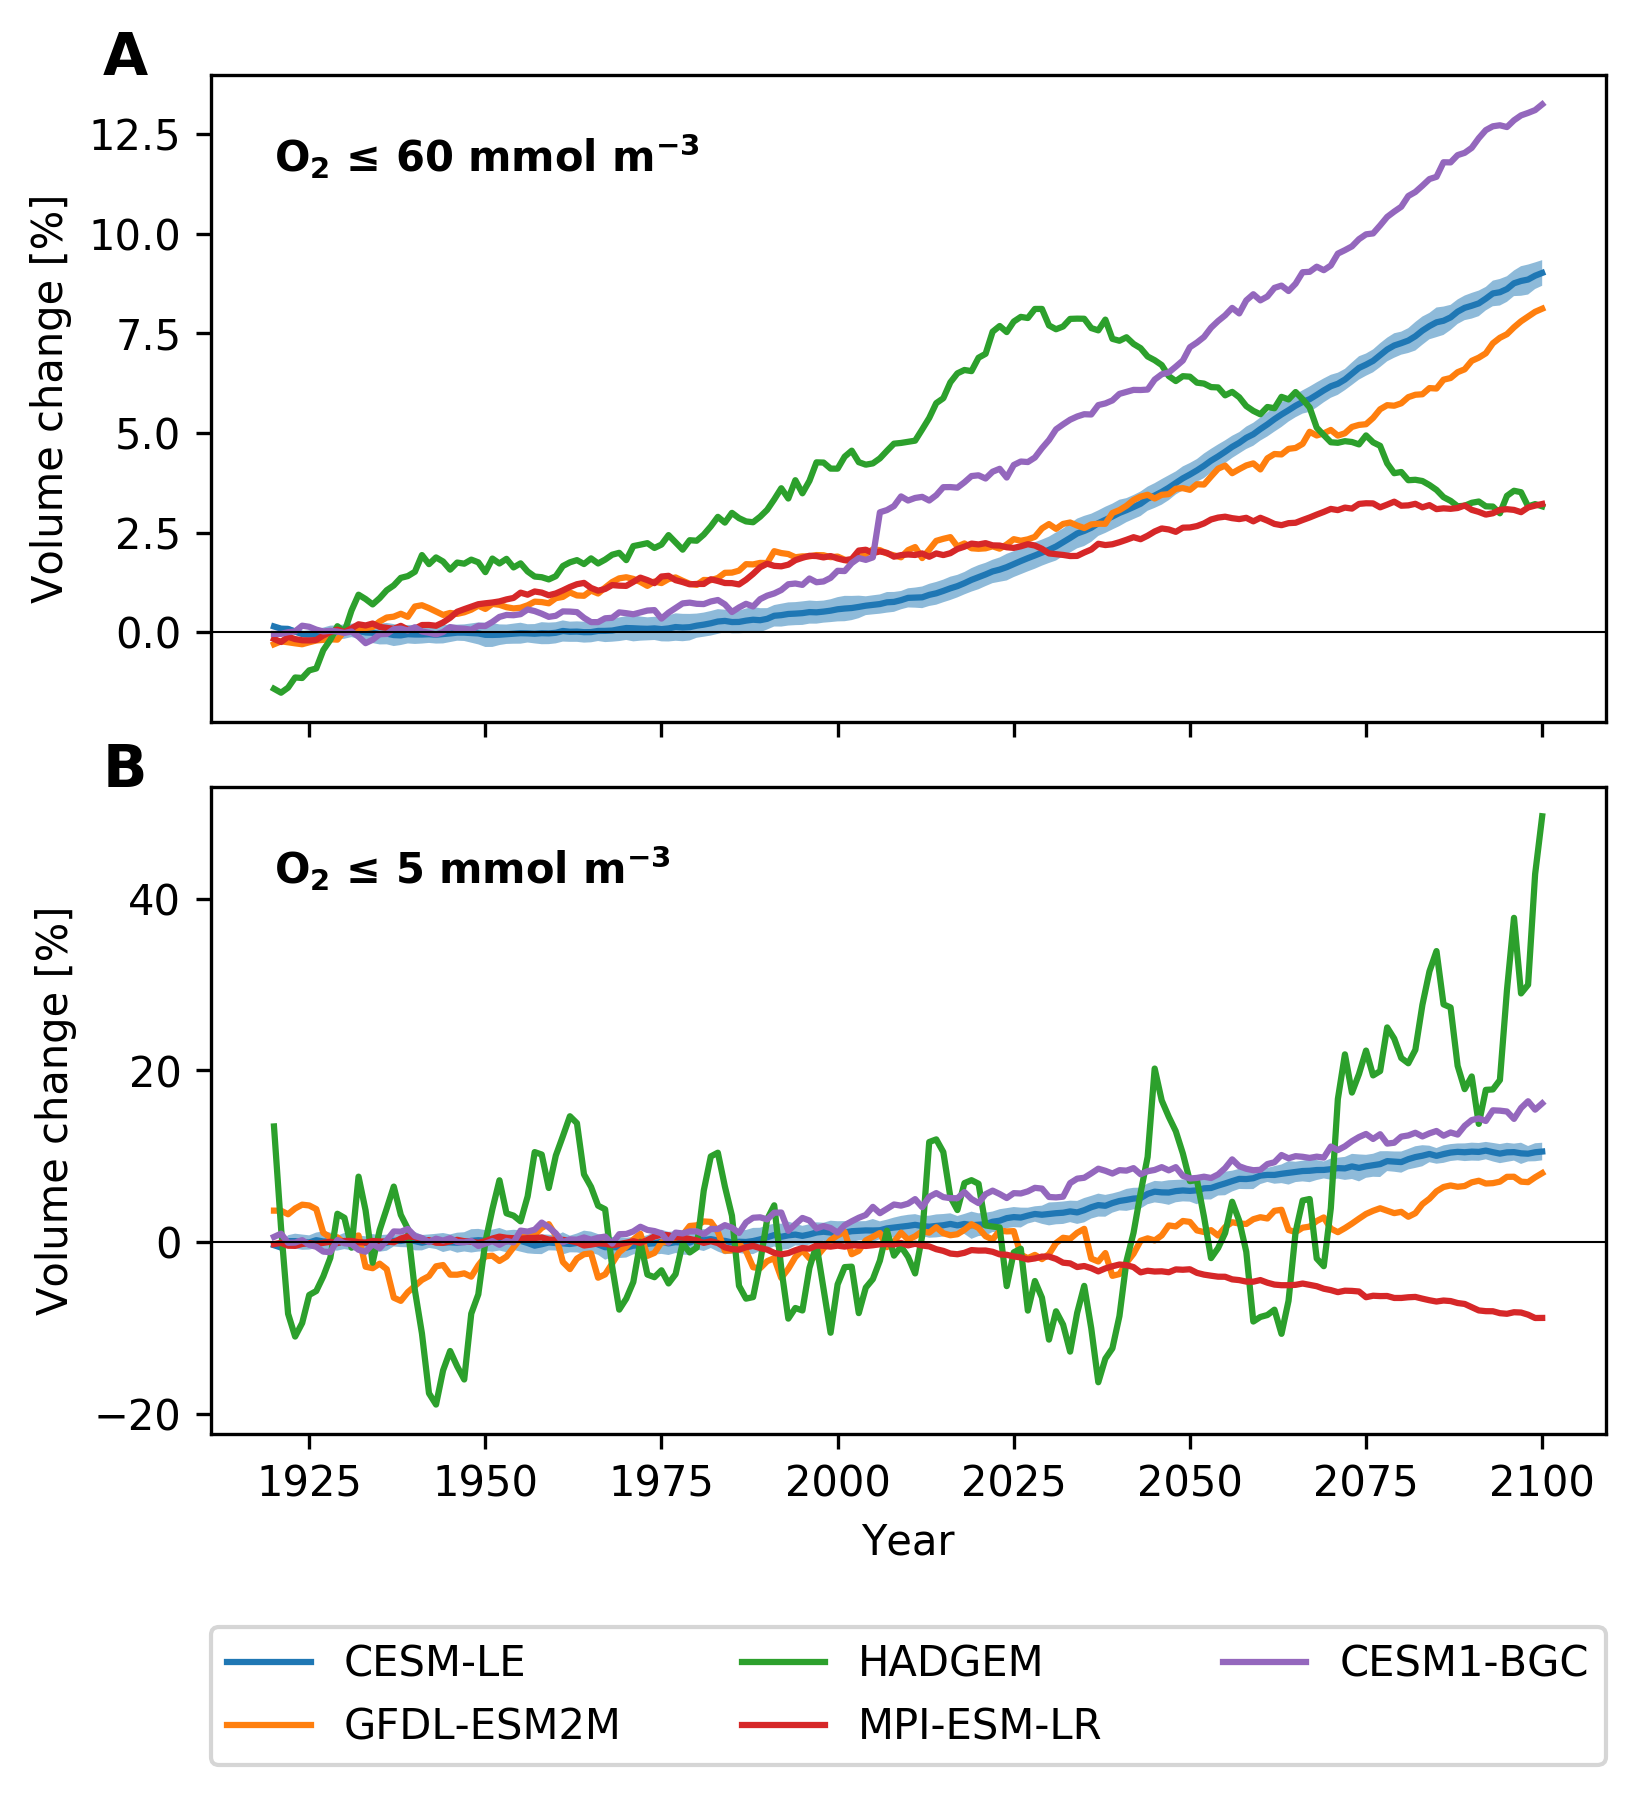

In [87]:
plot_name = os.path.join(diro['fig'],'volume-census.pdf')
fig = plt.figure(figsize=(6,6),dpi=300)

gs = gridspec.GridSpec(2,1)

label = {'V60INT': u'O$_2$ ≤ 60 mmol m$^{-3}$',
         'V50INT': u'O$_2$ ≤ 50 mmol m$^{-3}$',
         'V5INT': u'O$_2$ ≤ 5 mmol m$^{-3}$'}
for i,v in enumerate(['V60INT','V5INT']):
    ax = fig.add_subplot(gs[i,0])
    
    ax.fill_between(ds.time,(dsa[v]-dss[v]),(dsa[v]+dss[v]),alpha=0.5)
    ax.plot(ds.time,dsa[v],label='CESM-LE')
    for m in range(len(cmip.model)):
        ax.plot(cmip.time,cmip[v][m,:],label=model.keys()[m])
    ylm = ax.get_ylim()
    
    ax.text(1920,ylm[1]-0.15*np.diff(ylm),label[v],fontweight='bold')
    ax.set_ylabel('Volume change [%]')

    ax.axhline(0,linewidth=0.5,color='black')


axs = fig.get_axes()
axs[0].set_xticklabels([])
axs[-1].set_xlabel('Year')

handles, labels = axs[0].get_legend_handles_labels()
#axs[0].legend(handles,labels,bbox_to_anchor=(0.,0.25),columns=2)

axs[-1].legend(bbox_to_anchor=(0., -0.4, 1., .102),
           ncol=3, mode="expand", borderaxespad=0.)
gs.update(hspace=0.1)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,ax in enumerate(axs):
    p = ax.get_position()
    y = p.y1+0.00
    x = p.x0-0.06
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
    
plt.savefig(plot_name,bbox_inches='tight')